## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/wind.csv")
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
0,0,25.896492,-97.460358,Texas,onshore,7.46,31,2,0.433,1.997163,17495.14630,7575.398348,4.696747e+06
1,1,26.032654,-97.738098,Texas,onshore,7.45,31,10,0.414,9.945710,87124.42376,36069.511440,2.236310e+07
2,2,26.059063,-97.208252,Texas,onshore,8.18,31,2,0.506,2.633037,23065.40088,11671.092850,7.236078e+06
3,3,26.078449,-98.073364,Texas,onshore,7.17,31,16,0.363,14.185493,124264.92160,45108.166540,2.796706e+07
4,4,26.143227,-98.311340,Texas,onshore,7.06,31,16,0.358,13.542570,118632.91080,42470.582050,2.633176e+07


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,wind_speed,lcoe,capacity,capacity_factor,available_wind_power,available_energy,generated_energy,cost
79590,79590,41.837624,-117.217148,Nevada,onshore,6.79,52,16,0.309,12.047482,105535.9457,32610.60721,33915031.49
63264,63264,39.696823,-120.172119,California,onshore,6.93,47,16,0.349,12.808158,112199.4652,39157.61336,36808156.56
67794,67794,42.508434,-105.420929,Wyoming,onshore,7.09,30,16,0.326,13.715943,120151.6637,39169.44236,23501665.42
76743,76743,43.585987,-92.464874,Minnesota,onshore,7.76,32,16,0.489,17.983414,157534.7060,77034.47126,49302061.60
80060,80060,43.905441,-92.548767,Minnesota,onshore,7.64,32,14,0.432,15.016721,131546.4741,56828.07680,36369969.15


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:100000]
X_test = X[100000:]
y_train = y[:100000]
y_test = y[100000:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 0.29976876, -1.55213354,  0.51397118],
       [-0.19081527, -1.80102981,  0.51397118],
       [ 0.45349097, -0.55854175,  0.51397118],
       ...,
       [-0.98926974, -0.04632361,  0.51397118],
       [ 1.01246158,  2.31043674, -0.67408559],
       [-0.93654137,  1.82255592,  0.51397118]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [7]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor()

With a trained model, predictions can now be made.

In [8]:
#| label: prediction-comparisons

display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 83754.58	actual energy: 83847.86	predicted cost: 53602934.30	actual cost: 53662631.64
predicted energy: 71218.08	actual energy: 72733.57	predicted cost: 45579569.00	actual cost: 46549485.59
predicted energy: 12278.47	actual energy: 12532.50	predicted cost: 7367082.12	actual cost: 7519499.96


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [9]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[0.91837919 0.886822  ]
rmse	[   9016.1235774  6597654.69852586]
mape	[0.12685824 0.12691037]


#### Feature Importances

Feature importances give insights into the features that each decision tree in the random forest use to split most often. Results are portrayed in percentages.

In [10]:
#| label: feature-importances

features = ['lat','long','capacity',]

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
capacity: 20.135246241505772
lat: 35.00933261524246
long: 44.855421143251775


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [14]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.9109908237527048
RMSE Average: 3181739.2057383326
MAPE Average: 0.13390596472645255


,fit_time,score_time,test_r2,test_rmse,test_mape
0,35.631838,0.412091,0.908636,3.244508e+06,0.126463
1,35.085633,0.407737,0.909902,3.194235e+06,0.134273
2,34.784758,0.409132,0.912724,3.128678e+06,0.129694
3,34.819360,0.401673,0.908216,3.253428e+06,0.126229
4,34.879103,0.404808,0.907344,3.241619e+06,0.137367
5,34.481580,0.417363,0.915569,3.113150e+06,0.137573
6,35.357341,0.434344,0.908085,3.232867e+06,0.148030
7,37.669082,0.456003,0.915380,3.138264e+06,0.137533
8,37.000147,0.439912,0.913334,3.138594e+06,0.128061
9,34.930129,0.409387,0.910719,3.132047e+06,0.133837


### Graphs

Graphs of the Random Forest model fits on each of the input features, for each target.

ValueError: x has 3 columns but y has 2 columns

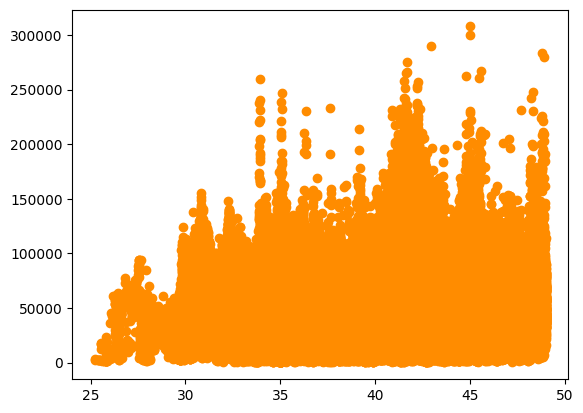

In [23]:
plot_x = pd.DataFrame()

plt.scatter(X.loc[:,["lat"]], y.loc[:,['generated_energy']], color='darkorange', label='data')
plt.plot(X_test, preds, color='c', label="model")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

A graph of the feature importances. This helps to visualize the magnitude of importance of each feature, and compare their impact against one another.

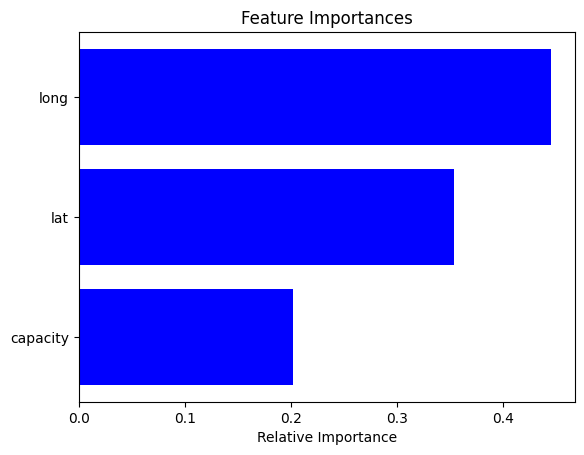

In [14]:
#| label: fig-feature-importances

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays the decision making process the model takes to arive at predictions.

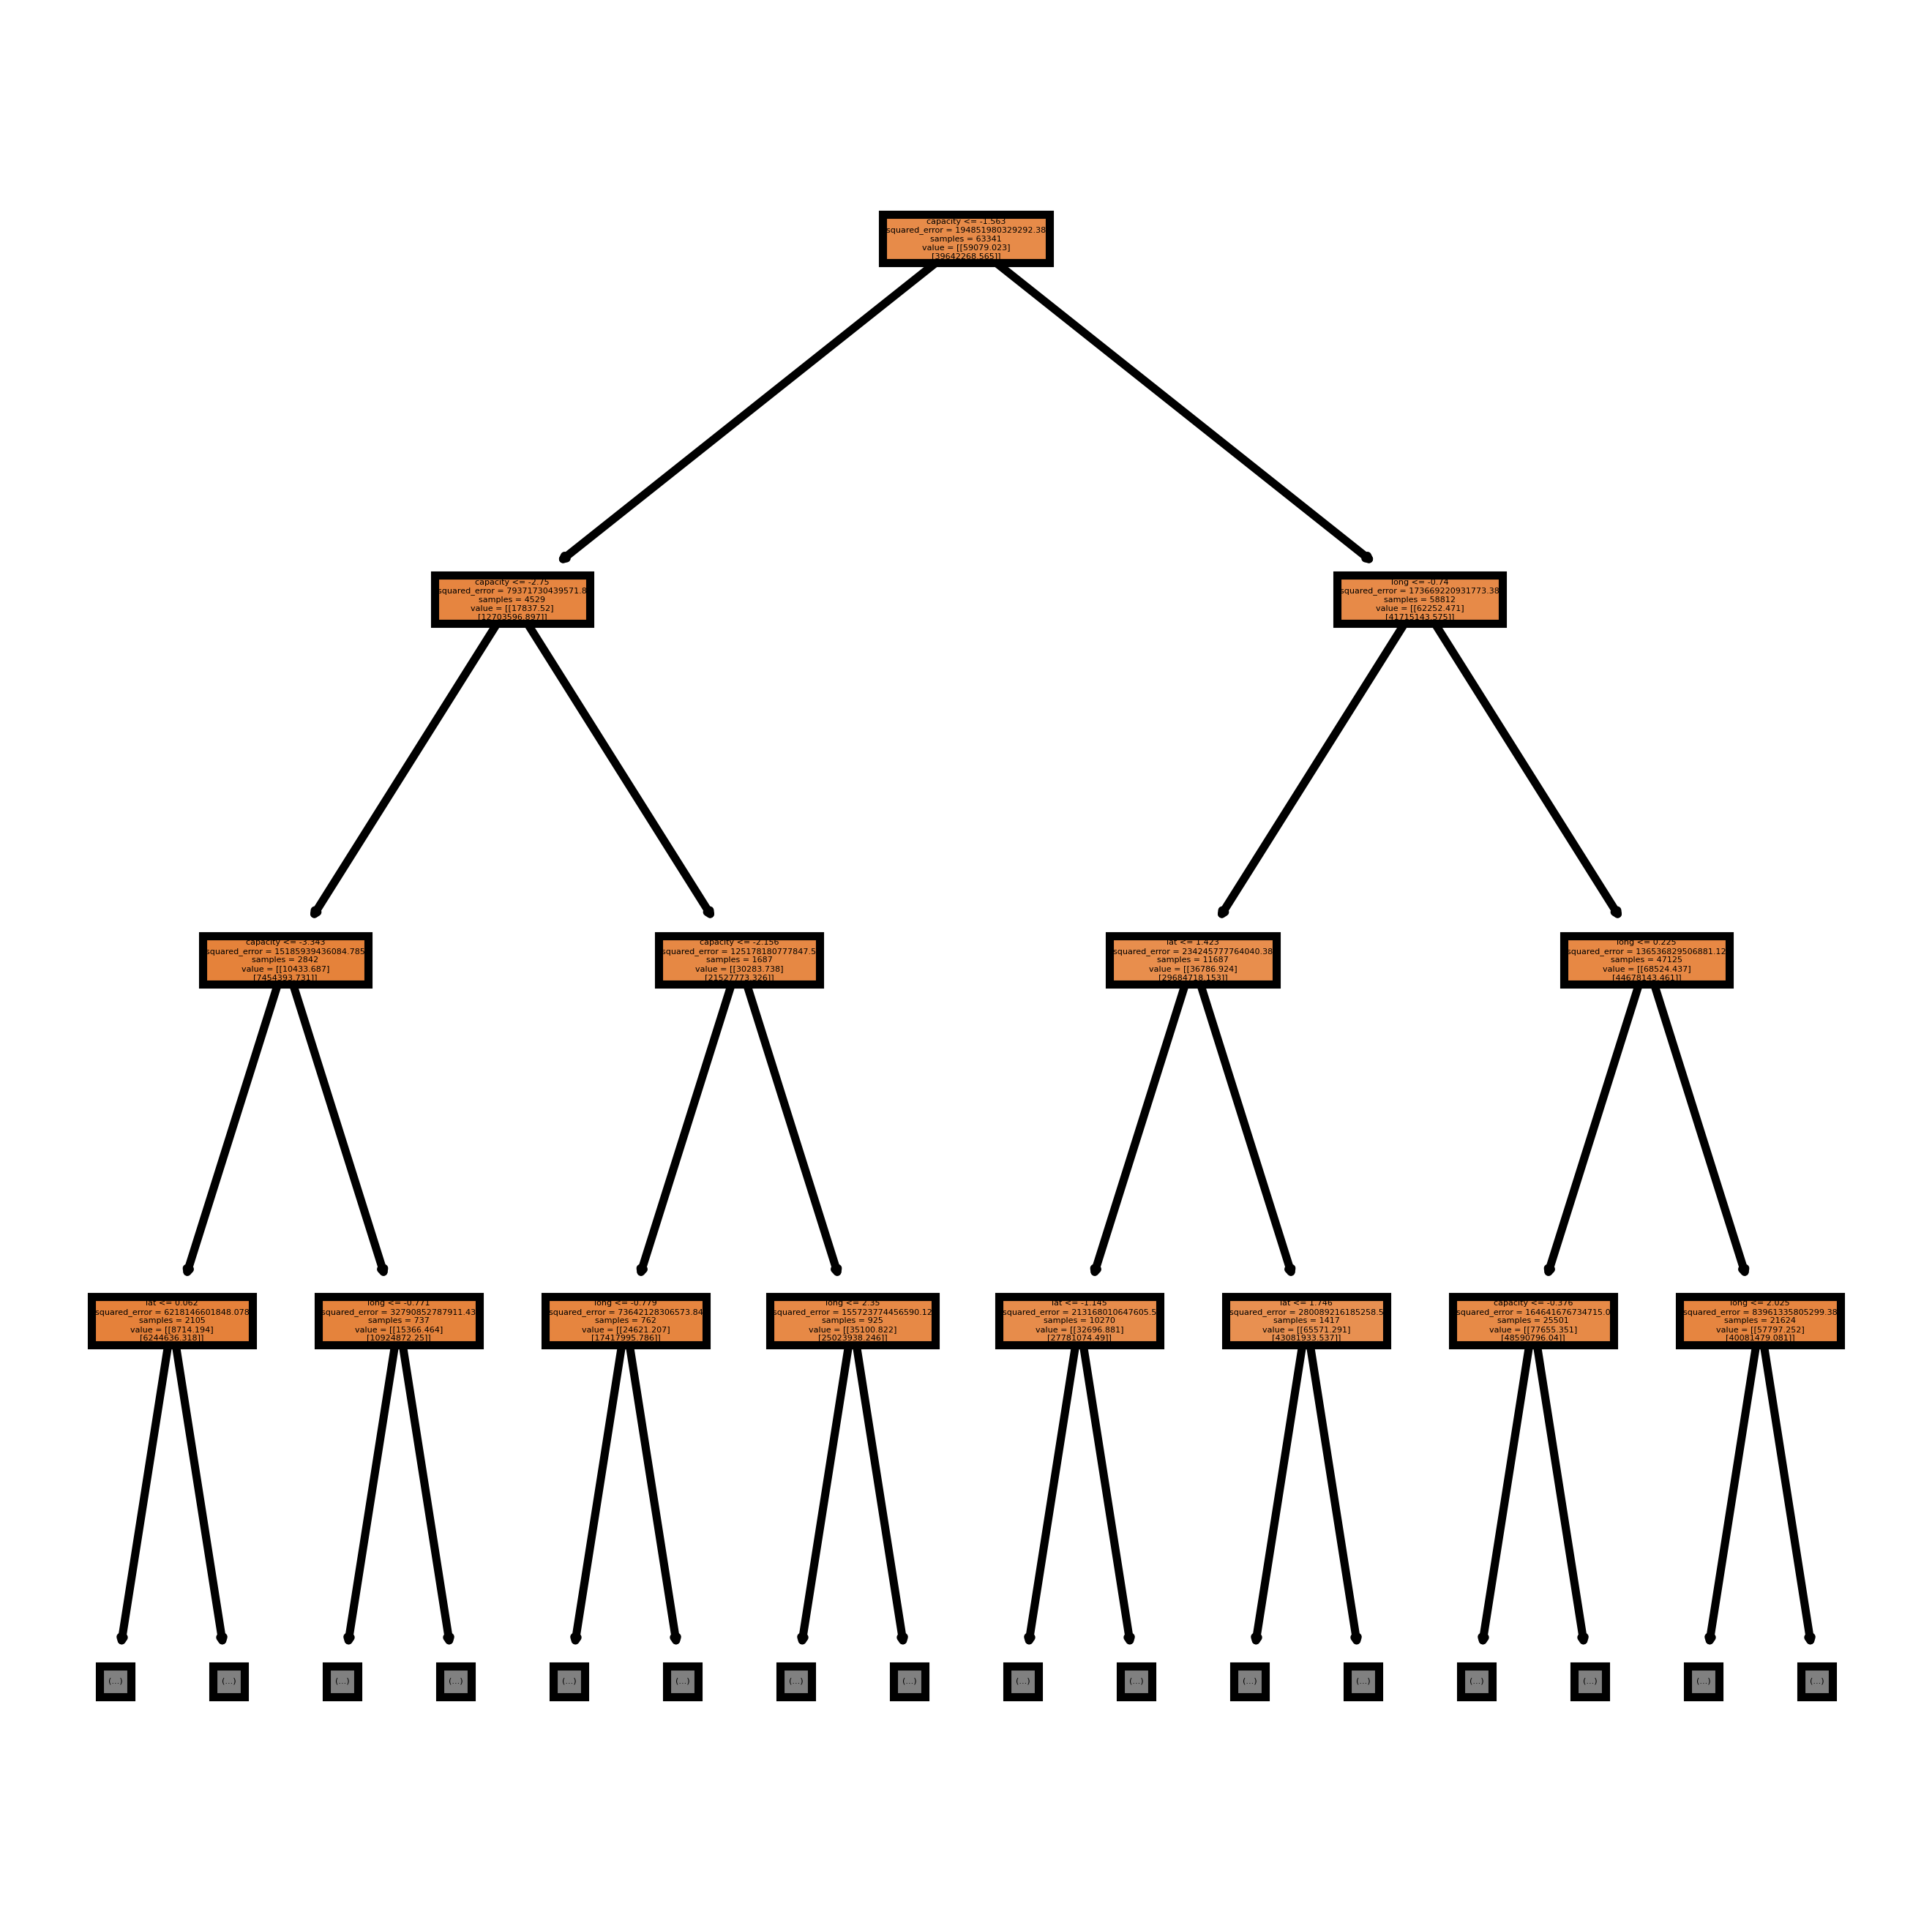

In [15]:
#| label: fig-decision-tree

fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()